In [1]:
 import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from lockdowndates.core import LockdownDates

from catboost import CatBoostRegressor
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
from datetime import timedelta, date

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [2]:
X, y = utils.get_train_data()
X_final_test = pd.read_parquet(Path("data") / "final_test.parquet")

X_train, y_train, X_test, y_test = utils.train_test_split_temporal(X, y, delta_threshold="30 days")


## Dense

In [3]:
num_features = ['temp', 'precip', 'windspeed', 'visibility']
cat_features = ['counter_id']
time_features = ['hour','month','weekday','day']

col_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(sparse=False), cat_features),
        ('time', FunctionTransformer(utils.encode_cyclical_features), time_features)
    ],
    remainder='passthrough'
)

In [7]:
cat = CatBoostRegressor(
    depth=12,
    iterations=1000,
    rsm=0.3,
    subsample=0.7
)

pipe = Pipeline([
    ('prepro',FunctionTransformer(utils.prepro)),
    ('col', col_transformer),
    ('model', cat)
])


pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Learning rate set to 0.107739
0:	learn: 1.5477099	total: 31.5ms	remaining: 31.5s
1:	learn: 1.4371181	total: 59.2ms	remaining: 29.6s
2:	learn: 1.3420752	total: 86.1ms	remaining: 28.6s
3:	learn: 1.2572751	total: 111ms	remaining: 27.6s
4:	learn: 1.1841485	total: 138ms	remaining: 27.4s
5:	learn: 1.1276760	total: 164ms	remaining: 27.2s
6:	learn: 1.0736074	total: 191ms	remaining: 27.1s
7:	learn: 1.0250647	total: 219ms	remaining: 27.2s
8:	learn: 0.9853124	total: 246ms	remaining: 27.1s
9:	learn: 0.9513224	total: 273ms	remaining: 27s
10:	learn: 0.9147655	total: 300ms	remaining: 27s
11:	learn: 0.8857464	total: 325ms	remaining: 26.8s
12:	learn: 0.8567974	total: 351ms	remaining: 26.7s
13:	learn: 0.8315996	total: 374ms	remaining: 26.3s
14:	learn: 0.8117770	total: 401ms	remaining: 26.4s
15:	learn: 0.7936416	total: 427ms	remaining: 26.3s
16:	learn: 0.7754401	total: 451ms	remaining: 26.1s
17:	learn: 0.7601766	total: 476ms	remaining: 26s
18:	learn: 0.7462145	total: 502ms	remaining: 25.9s
19:	learn: 0.7

In [ ]:
submission = pipe.predict(X_final_test)
pd.Series(submission).to_frame().rename_axis('Id').rename(columns={0:'log_bike_count'}).to_csv('submission43_101223.csv')

In [8]:
#catboost_predictions = pipe.predict(X)
catboost_predictions_train = pipe.predict(X_train)
catboost_predictions_test = pipe.predict(X_test)

In [9]:
pipe2 = Pipeline([
    ('prepro',FunctionTransformer(utils.prepro)),
    ('col', col_transformer),
])
X_train_prepro = pipe2.fit_transform(X_train)
X_test_prepro = pipe2.fit_transform(X_test)

In [13]:

X_train_with_predictions = np.hstack((X_train_prepro, catboost_predictions_train.reshape(-1, 1)))
X_test_with_predictions = np.hstack((X_test_prepro, catboost_predictions_test.reshape(-1, 1)))

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_with_predictions.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Pour la régression

model.compile(optimizer='adam', loss='mean_squared_error')

#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train_with_predictions, y_train, epochs=25, batch_size=32,validation_data=(X_test_with_predictions, y_test))#callbacks=[early_stopping], )

mse = model.evaluate(X_test_with_predictions, y_test)
# Évaluation du modèle
model.evaluate(X_test_with_predictions, y_test)

Epoch 1/25
14266/14266 [==============================] - 8s 572us/step - loss: 1.9798 - val_loss: 0.6007
Epoch 2/25
14266/14266 [==============================] - 8s 568us/step - loss: 0.1453 - val_loss: 0.1851
Epoch 3/25
14266/14266 [==============================] - 8s 569us/step - loss: 0.1073 - val_loss: 0.1837
Epoch 4/25
14266/14266 [==============================] - 8s 570us/step - loss: 0.1012 - val_loss: 0.1869
Epoch 5/25
14266/14266 [==============================] - 8s 568us/step - loss: 0.0978 - val_loss: 0.1930
Epoch 6/25
14266/14266 [==============================] - 8s 571us/step - loss: 0.0958 - val_loss: 0.1969
Epoch 7/25
14266/14266 [==============================] - 8s 571us/step - loss: 0.0944 - val_loss: 0.1951
Epoch 8/25
14266/14266 [==============================] - 8s 566us/step - loss: 0.0933 - val_loss: 0.1884
Epoch 9/25
14266/14266 [==============================] - 8s 576us/step - loss: 0.0929 - val_loss: 0.1945
Epoch 10/25
14266/14266 [=====================

0.18471907079219818

## Evaluate Overfitting

Root Mean Squared Error (CatBoost): 0.4266953375361533


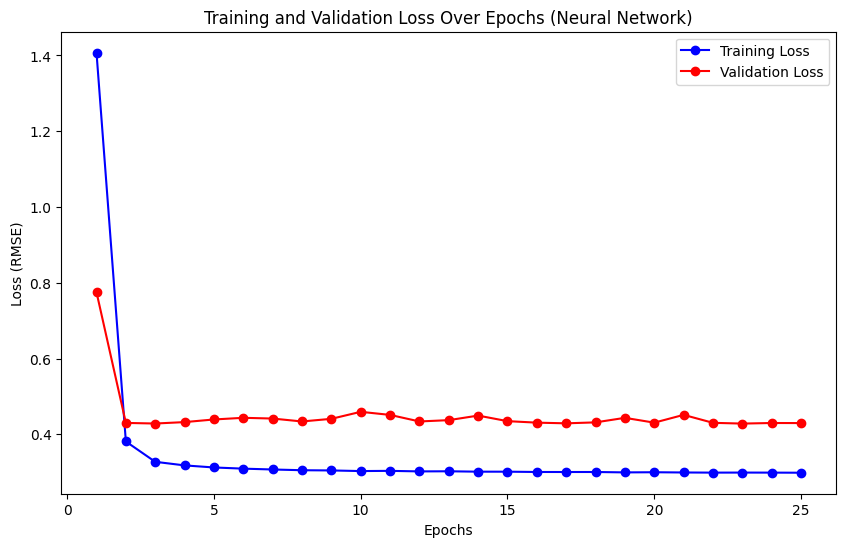

In [17]:
# Evaluate CatBoost on the test set
rmse_catboost = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (CatBoost): {rmse_catboost}')

# Plotting training and validation loss for the Neural Network
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 6))

# Plotting training loss
plt.plot(epochs, np.sqrt(history_dict['loss']), 'bo-', label='Training Loss')

# Plotting validation loss
plt.plot(epochs, np.sqrt(history_dict['val_loss']), 'ro-', label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs (Neural Network)')
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.savefig('train_val_loss_25_epochs.jpg', format='jpg')
plt.show()

## Predictions and Export

In [43]:
y_pred = model.predict(X_test_with_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

1260/1260 [==============================] - 0s 315us/step
Root Mean Squared Error: 0.27530904722803934


In [52]:
X_final_test_scaled = pipe.predict(X_final_test)
X_final_test_with_predictions = np.hstack((pipe2.fit_transform(X_final_test), X_final_test_scaled.reshape(-1, 1)))
submission = model.predict(X_final_test_with_predictions)
pd.DataFrame(submission, columns=["log_bike_count"]).rename_axis('Id').to_csv('submission56_deep_101223.csv')

1608/1608 [==============================] - 0s 296us/step


In [13]:
best_sub = pd.read_csv('submission17_91223.csv')
rmse = np.sqrt(mean_squared_error(best_sub['log_bike_count'], predictions))
print(f'RMSE:{rmse}')

RMSE:0.15017399128824682


In [14]:
pd.DataFrame(predictions, columns=["log_bike_count"]).rename_axis('Id').to_csv('submission34_deep_101223.csv')